In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim



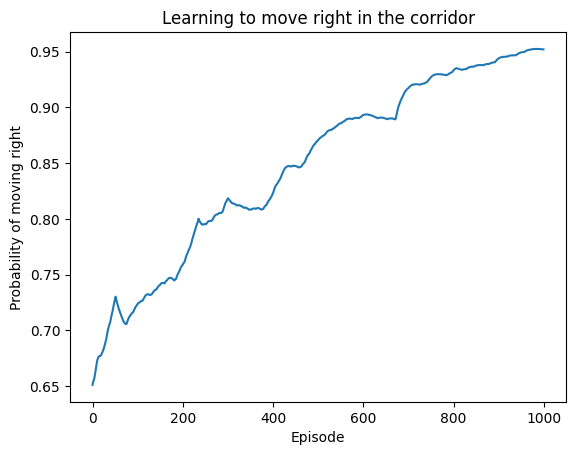

In [20]:
class CorridorGridWorld:
    def __init__(self):
        self.states = [0,1,2,3]
        self.start_state = 0
        self.goal_state = 3
        self.actions = ["left", "right"]
        self.state = self.start_state

    def reset(self):
        return self.start_state
    
    def step(self,action):
        if self.state == 0:
            if action == 1:
                self.state = 1
        elif self.state == 1:
            if action == 1:
                self.state = 2
        elif self.state == 2:
            if action == 1:
                self.state = 1
            else:
                self.state = 3
        elif self.state == 3:
            if action == 0:
                self.state = 2
            else:
                self.state = self.goal_state
        reward = -1
        done = self.state == self.goal_state
        return self.state, reward, done
    
class PolicyNetwork(nn.Module):
    def __init__(self,state_size,action_size):
        super(PolicyNetwork,self).__init__()
        self.fc = nn.Linear(state_size,action_size)

    def forward(self,state):
        logits = self.fc(state)
        return torch.softmax(logits,dim=-1)

def reiforce(env,policy_net,optimizer,num_episodes=1000,gamma=0.99):
    episode_rewards = []
    right_probabilities = []

    for episode in range(num_episodes):
        state = env.reset()
        log_probs = []
        rewards =[]
        done = False

        while not done:
            state_tensor = torch.FloatTensor([state])
            action_probs = policy_net(state_tensor)
            action = torch.multinomial(action_probs,1).item()
            log_prob = torch.log(action_probs[action])
            log_probs.append(log_prob)

            next_state, reward, done = env.step(action)
            rewards.append(reward)
            state = next_state
        G = 0
        returns = []
        for r in rewards[::-1]:
            G = r + gamma * G
            returns.insert(0,G)
        returns = torch.tensor(returns)

        loss = -sum(log_probs[i] * returns[i] for i in range(len(log_probs)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            state_tensor = torch.FloatTensor([env.start_state])
            action_probs = policy_net(state_tensor)
            right_probabilities.append(action_probs[1].item())  

    return right_probabilities

env = CorridorGridWorld()
policy_net = PolicyNetwork(state_size=1,action_size=2)
optimizer = optim.Adam(policy_net.parameters(),lr=0.01)

right_probabilities = reiforce(env,policy_net,optimizer,num_episodes=1000)

import matplotlib.pyplot as plt
plt.plot(right_probabilities)
plt.xlabel("Episode")
plt.ylabel("Probability of moving right")
plt.title("Learning to move right in the corridor")
plt.show()


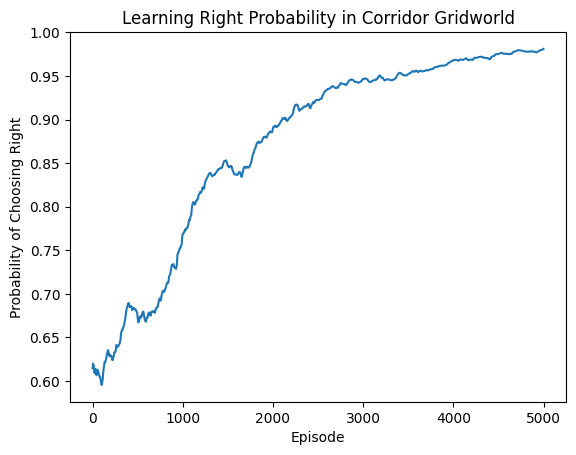

In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 環境の定義
class CorridorGridworld:
    def __init__(self):
        self.states = [0, 1, 2, 3]  # 状態0:開始, 状態1, 状態2, 状態3
        self.start_state = 0
        self.goal_state = 3
        self.actions = ["left", "right"]
        self.state = self.start_state
    
    def reset(self):
        self.state = self.start_state
        return self.state
    
    def step(self, action):
        if self.state == 0:
            if action == 1:  # right
                self.state = 1
        elif self.state == 1:
            if action == 1:  # right
                self.state = 2
        elif self.state == 2:
            if action == 1:  # right (逆転: 左へ移動)
                self.state = 1
            else:  # left (逆転: 右へ移動)
                self.state = 3
        elif self.state == 3:
            if action == 1:  # right
                self.state = self.goal_state  # ゴール
            elif action == 0:  # left
                self.state = 2  # 状態2に戻る
                self.state = self.goal_state  # ゴール
        
        reward = -1  # 各ステップで -1 の報酬
        done = self.state == self.goal_state
        return self.state, reward, done

# 方策ネットワーク（ソフトマックス方策）
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(state_size, action_size)
    
    def forward(self, state):
        logits = self.fc(state)
        return torch.softmax(logits, dim=-1)  # ソフトマックス方策

# 方策勾配法（REINFORCE）
def reinforce(env, policy_net, optimizer, num_episodes=5000, gamma=0.99):
    episode_rewards = []
    right_probabilities = []
    
    for episode in range(num_episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        done = False
        
        while not done:
            state_tensor = torch.FloatTensor([state])
            action_probs = policy_net(state_tensor)
            action = torch.multinomial(action_probs, 1, replacement=True).item()  # 確率に基づきサンプリング
            log_prob = torch.log(action_probs[action])
            log_probs.append(log_prob)
            
            next_state, reward, done = env.step(action)
            rewards.append(reward)
            state = next_state
        
        # 割引累積報酬の計算
        G = 0
        returns = []
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)
        
        # 損失計算と方策の更新
        loss = -sum(log_probs[i] * returns[i] for i in range(len(log_probs)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 右を選ぶ確率の記録
        with torch.no_grad():
            state_tensor = torch.FloatTensor([env.start_state])
            action_probs = policy_net(state_tensor)
            right_probabilities.append(action_probs[1].item())
    
    return right_probabilities

# 環境とネットワークの初期化
env = CorridorGridworld()
policy_net = PolicyNetwork(state_size=1, action_size=2)
optimizer = optim.Adam(policy_net.parameters(), lr=0.005)

# 方策勾配法（REINFORCE）で学習
right_probs = reinforce(env, policy_net, optimizer, num_episodes=5000)

# 学習結果の可視化
import matplotlib.pyplot as plt
plt.plot(right_probs)
plt.xlabel("Episode")
plt.ylabel("Probability of Choosing Right")
plt.title("Learning Right Probability in Corridor Gridworld")
plt.show()


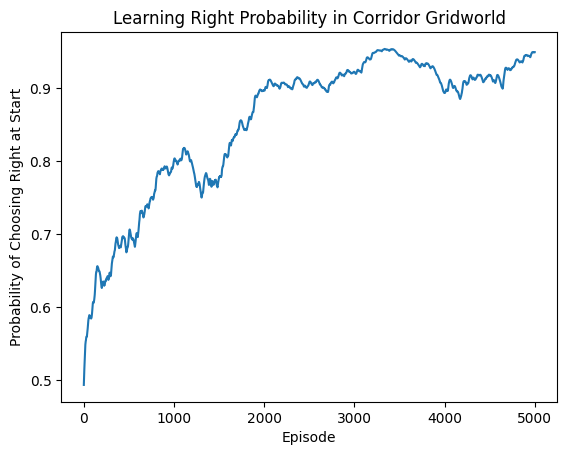

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# === 環境の定義 ===
class CorridorGridworld:
    def __init__(self):
        # 状態は0～4
        # 0: 開始, 4: ゴール, 1～3: 中間状態
        self.states = [0, 1, 2, 3, 4]
        self.start_state = 0
        self.goal_state = 4
        # 行動: 0 = left, 1 = right
        self.actions = [0, 1]
        self.state = self.start_state

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        # 各状態での行動の意味を定義します
        # ※ここでは一例として、以下のような遷移にしています。
        if self.state == 0:
            # 状態0では右（1）のみで前進、左（0）は何もしない（自己ループ）
            if action == 1:
                self.state = 1
            # else: self.stateはそのまま
        elif self.state == 1:
            # 状態1では右で前進、左で後退
            if action == 1:
                self.state = 2
            elif action == 0:
                self.state = 0
        elif self.state == 2:
            # 状態2では、行動を「反転」させる（右を選ぶと実は左へ、左を選ぶと右へ）
            if action == 1:
                self.state = 1  # 右を選んだら左方向へ
            elif action == 0:
                self.state = 3  # 左を選んだら右方向へ
        elif self.state == 3:
            # 状態3では、右でゴール、左で1ステップ戻る
            if action == 1:
                self.state = self.goal_state
            elif action == 0:
                self.state = 2
        # ゴール状態（4）に達していればエピソード終了
        reward = -1  # どのステップも一定のコストを与える
        done = self.state == self.goal_state
        return self.state, reward, done

# === 方策ネットワークの定義 ===
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyNetwork, self).__init__()
        # ここでは1層の線形層＋ソフトマックス
        self.fc = nn.Linear(state_size, action_size)
    
    def forward(self, state):
        logits = self.fc(state)
        return torch.softmax(logits, dim=-1)

# 状態をワンホット表現に変換する関数
def one_hot(state, state_size):
    vec = torch.zeros(state_size)
    vec[state] = 1.0
    return vec

# === REINFORCEによる学習 ===
def reinforce(env, policy_net, optimizer, num_episodes=5000, gamma=0.99):
    episode_rewards = []
    right_probabilities = []
    state_size = len(env.states)
    
    for episode in range(num_episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        done = False

        while not done:
            # ワンホット表現に変換
            state_tensor = one_hot(state, state_size).unsqueeze(0)  # バッチ次元を追加
            action_probs = policy_net(state_tensor)
            # 確率的サンプリング
            m = torch.distributions.Categorical(action_probs)
            action = m.sample().item()
            log_prob = m.log_prob(torch.tensor(action))
            log_probs.append(log_prob)
            
            next_state, reward, done = env.step(action)
            rewards.append(reward)
            state = next_state

        # 割引累積報酬の計算
        G = 0
        returns = []
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)
        # エピソード内の報酬のスケーリング（正規化）※必須ではありませんが学習の安定化に有効な場合もあります
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # 損失の計算とパラメータ更新
        loss = 0
        for log_prob, Gt in zip(log_probs, returns):
            loss -= log_prob * Gt  # 勾配上昇のためマイナス
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 学習経過の記録：開始状態での右を選ぶ確率を記録
        with torch.no_grad():
            start_state_tensor = one_hot(env.start_state, state_size).unsqueeze(0)
            action_probs = policy_net(start_state_tensor)
            # インデックス1が右の行動の確率
            right_probabilities.append(action_probs[0, 1].item())

    return right_probabilities

# === 環境とネットワークの初期化 ===
env = CorridorGridworld()
state_size = len(env.states)  # 5
action_size = len(env.actions)  # 2
policy_net = PolicyNetwork(state_size, action_size)
optimizer = optim.Adam(policy_net.parameters(), lr=0.005)

# === 学習 ===
right_probs = reinforce(env, policy_net, optimizer, num_episodes=5000)

# === 結果の可視化 ===
plt.plot(right_probs)
plt.xlabel("Episode")
plt.ylabel("Probability of Choosing Right at Start")
plt.title("Learning Right Probability in Corridor Gridworld")
plt.show()
